In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

from sync_plots import calc_and_plot_Q_and_S, set_size, DOCUMENT_WIDTH
from sync_calcs import *
from qutip import *

# Unitary Data

In [2]:
states = np.load('results/unitary/unitary-v2-corrected.npy')

# Populations
ups = [state[0, 0].real for state in states]
downs = [state[1, 1].real for state in states]

In [3]:
detuning = 5 * 3 * 0.1
signal_strength = 5 * 2 * 0.1

H = signal_hamiltonian(detuning, signal_strength)
t = np.linspace(0, 16, 100)
result = mesolve(H, ket2dm(basis(2, 0)), t * 0.2)

cont_ups = [state[0, 0].real for state in result.states]
cont_downs = [state[1, 1].real for state in result.states]

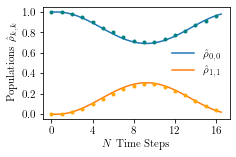

In [4]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

ax.plot([0, *(t + 0.5)], [1, *cont_ups], "-", label=r"$\hat\rho_{0,0}$")
ax.plot([0, *(t + 0.5)], [0, *cont_downs], "-", label=r"$\hat\rho_{1,1}$")
ax.plot(ups, ".", c="teal")
ax.plot(downs, ".", c="orange")

ax.set_xlabel(r"$N$ Time Steps")
ax.set_ylabel(r"Populations $\hat\rho_{k,k}$")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MultipleLocator(base=4))
ax.yaxis.set_major_locator(MultipleLocator(base=0.2))

fig.savefig("results/unitary/unitary-population-cycle.pdf", bbox_inches="tight")


In [5]:
# Coherences
coh_arg = [np.angle(state[1, 0]) / np.pi for state in states]
coh_mod = [np.abs(state[1, 0]) for state in states]

cont_coh_arg = [np.angle(state[1, 0]) / np.pi for state in result.states]
cont_coh_mod = [np.abs(state[1, 0]) for state in result.states]

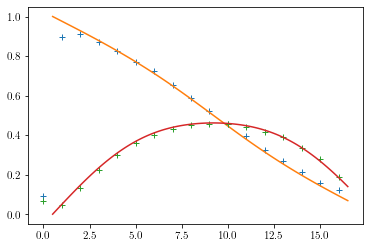

In [6]:
fig, ax = plt.subplots()

ax.plot(coh_arg, "+")
ax.plot(t + 0.5, -np.array(cont_coh_arg) + 1, "-")
ax.plot(coh_mod, "+")
ax.plot(t + 0.5, cont_coh_mod, "-")


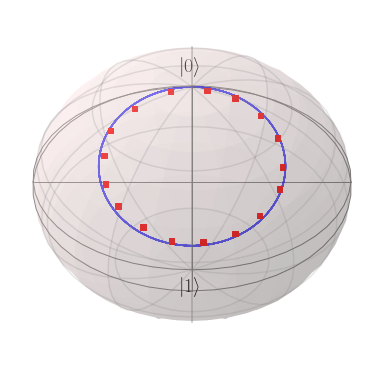

In [7]:
detuning = 0.3
signal_strength = 0.2

H = signal_hamiltonian(detuning, signal_strength)
result = mesolve(H, basis(2, 0), np.linspace(0, 100, 1000))

b = Bloch()
points = dm2bloch([Qobj(s) for s in states])
b.add_points(dm2bloch(result.states), 'l')
b.add_points(points, meth="s")
b.view = [0, 40]
b.xlabel = ['', '']
b.ylabel = ['', '']
b.show()

b.fig.savefig("results/unitary/unitary-bloch-sphere-cycle.pdf", bbox_inches="tight")

# Unitary + Loss

In [8]:
path = "results/unitary+loss-4-steps"
data = []

for i in range(2, 8):
    d = np.load(path + f"/loss-4-steps-{i}-corrected.npy")
    data.append(d)

mean_states = np.mean(data, axis=0)
std_states = np.std(data, axis=0)


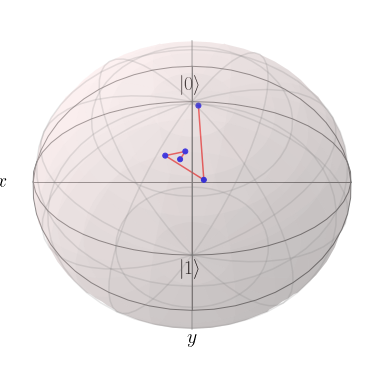

In [9]:
b = Bloch()
points = dm2bloch(mean_states)
b.add_points(points, meth="s")
b.add_points(points, meth="l")
b.view = [0, 50]
b.show()

In [10]:
ups = [state[0, 0].real for state in mean_states]
ups_std = [state[0, 0].real for state in std_states]

downs = [state[1, 1].real for state in mean_states]
downs_std = [state[1, 1].real for state in std_states]

loss_amp = 1
gain_amp = 0.1
dt = 0.4 # ?

detuning = 2.4
signal_strength = 1.6

cont_data = np.load(path + '/L+U+cont-aprox-sim.npy')

cont_ups = [state[0, 0].real for state in cont_data]
cont_downs = [state[1, 1].real for state in cont_data]

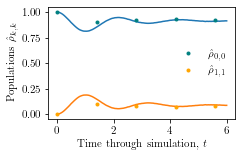

In [11]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

sim_dt = 0.4
scale = 1 + sim_dt

ax.plot(np.arange(len(cont_downs)) * 0.05, cont_ups)
ax.plot(np.arange(len(cont_downs)) * 0.05, cont_downs)

ax.plot(np.arange(len(ups)) * scale, ups, ".", c="teal", label=r"$\hat\rho_{0,0}$")
ax.plot(np.arange(len(downs)) * scale, downs, ".", c="orange", label=r"$\hat\rho_{1,1}$")

ax.set_xlabel(r"Time through simulation, $t$")
ax.set_ylabel(r"Populations $\hat\rho_{k,k}$")
# ax.xaxis.set_major_locator(MultipleLocator(base=1))
ax.legend(frameon=False)

fig.savefig(path + "/populations.pdf", bbox_inches="tight")


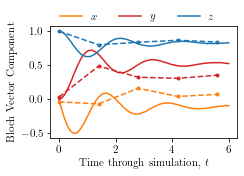

In [12]:
cont_points = dm2bloch(cont_data)
points = dm2bloch(mean_states)

fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

for i, (ccoord, coord) in enumerate(zip(cont_points, points)):
    if i == 0:
        label = '$x$'
        c='tab:orange'
    elif i == 1:
        label = '$y$'
        c='tab:red'
    elif i == 2:
        label='$z$'
        c='tab:blue'
    ax.plot(np.arange(len(coord)) * scale, coord, ".--", c=c)
    ax.plot(np.arange(len(ccoord)) * 0.05, ccoord, label=label, c=c)
ax.legend(ncol=3, frameon=False, loc=3, bbox_to_anchor=(0, 0.95))

ax.set_ylabel('Bloch Vector Component')
ax.set_xlabel(r'Time through simulation, $t$')

fig.savefig(path + "/bloch-vector.pdf", bbox_inches="tight")

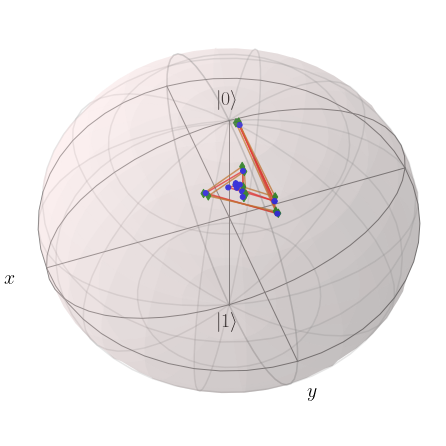

In [13]:
b = Bloch(figsize=[6, 6])

for d in data:
    points = dm2bloch(d)
    b.add_points(points, meth="s")
    b.add_points(points, meth="l")

b.view = [-20, 50]
b.show()

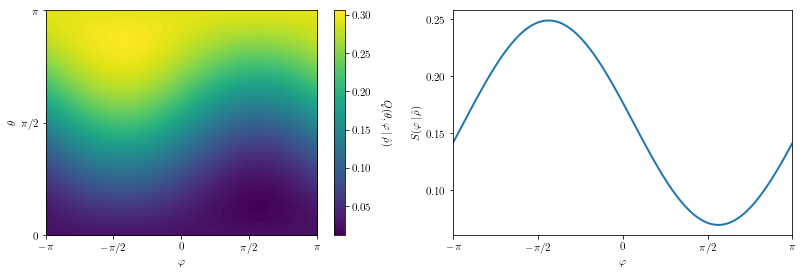

In [14]:
from sync_plots import calc_and_plot_Q_and_S
from qiskit.quantum_info import partial_trace

ss = mean_states[-1]
fig, *_ = calc_and_plot_Q_and_S(Qobj(ss), method="qutip")

fig.savefig(path + "/q-func-sync-measure.pdf", bbox_inches="tight")

# Loss V6

In [15]:
path = ""
data = []

cont_data = np.load('loss-v6-cont.npy')

# for i in range(2, 5):
#     d = np.load(path + f'u+l+g-{i}-corrected.npy')
#     data.append(d)

# mean_states = np.mean(data, axis=0)
# std_states = np.std(data, axis=0)

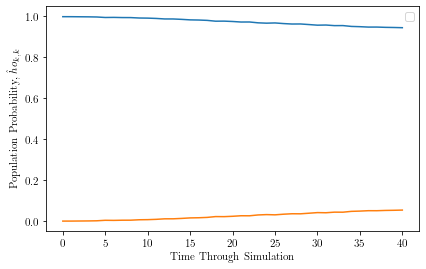

In [16]:
cont_ups = [state[0, 0].real for state in cont_data]
cont_downs = [state[1, 1].real for state in cont_data]

fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH))

ax.plot(cont_ups)
ax.plot(cont_downs)

ax.set_xlabel("Time Through Simulation")
ax.set_ylabel("Population Probability, $\hat\rho_{k,k}$")
# ax.xaxis.set_major_locator(MultipleLocator(base=1))
ax.legend()

# fig.savefig(path + "/populations.pdf", bbox_inches="tight")

# Gain + Loss

In [17]:
path = "results/unitary+loss+gain"
data = []

for i in range(2, 5):
    d = np.load(path + f'/u+l+g-{i}-corrected.npy')
    data.append(d)

mean_states = np.mean(data, axis=0)
std_states = np.std(data, axis=0)

In [18]:
detuning = 8 * 3 * 0.1
signal_strength = 8 * 2 * 0.1

gain_amp = 0.1
loss_amp = 1

loss, gain = get_disipators(gain_amp, loss_amp)

H = signal_hamiltonian(detuning, signal_strength)
t = np.linspace(0, 100, 100)
result = mesolve(H, ket2dm(basis(2, 0)), t * 0.2, c_ops=[loss, gain])

cont_ups = [state[0, 0].real for state in result.states]
cont_downs = [state[1, 1].real for state in result.states]

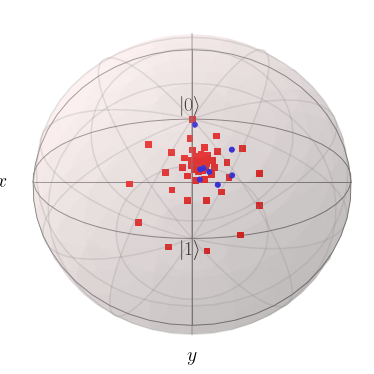

In [19]:
b = Bloch()

# b.add_points(dm2bloch(mean_states), meth="l")
b.add_points(dm2bloch(mean_states), meth="s")
b.add_points(dm2bloch(result.states), meth="s")

b.view = [0, 60]
b.show()

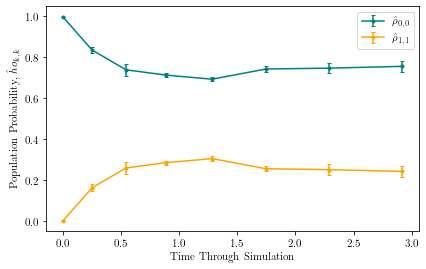

In [20]:
ups = [state[0, 0].real for state in mean_states]
ups_std = [state[0, 0].real for state in std_states]

downs = [state[1, 1].real for state in mean_states]
downs_std = [state[1, 1].real for state in std_states]

dts = (np.logspace(0.4, 0.8, 7, endpoint=True)) / 10
t = [0, *np.cumsum(dts)]

fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH))

ax.errorbar(t, ups, fmt=".-", yerr=ups_std, c="teal", capsize=2, label=r"$\hat\rho_{0,0}$")
ax.errorbar(t, downs, fmt=".-", yerr=downs_std, c="orange", capsize=2, label=r"$\hat\rho_{1,1}$")

ax.set_xlabel("Time Through Simulation")
ax.set_ylabel("Population Probability, $\hat\rho_{k,k}$")
# ax.xaxis.set_major_locator(MultipleLocator(base=1))
ax.legend()

fig.savefig(path + "/populations.pdf", bbox_inches="tight")

# Gain + Loss 2

In [21]:
data = []

for i in range(1, 3):
    d = np.load(f'ulg-12-steps-{i}.npy')
    data.append(d)

mean_states = np.mean(data, axis=0)
std_states = np.std(data, axis=0)


d = np.load('ulg-cont.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'ulg-12-steps-1.npy'

In [ ]:
def normalize(v):
    lengths = np.linalg.norm(v, ord=1)
    print(lengths)

In [ ]:
points = dm2bloch(mean_states)

v = np.array(points)
normed = v / np.sqrt(np.sum(v**2, axis=0))


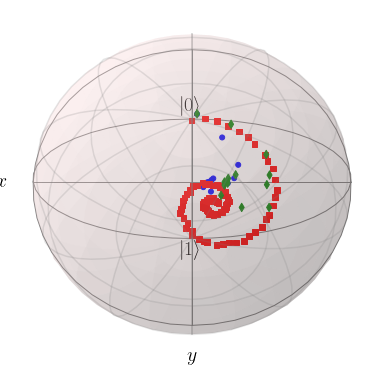

In [ ]:
b = Bloch()

b.add_points(points, meth="s")
# b.add_points(points, meth="l")

b.add_points(dm2bloch(d), meth="s")
b.add_points(normed, meth="s")
b.view = [0, 60]
b.show()


Text(0.5, 0, 'Time Through Simulation, $t$')

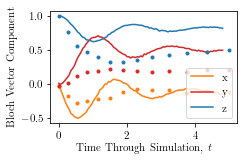

In [ ]:
cont_points = dm2bloch(d)

fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

dts = (np.logspace(0.4, 0.8, 12, endpoint=True)) / 10
t = [0, *np.cumsum(dts)]

for i, (ccoord, coord) in enumerate(zip(cont_points, points)):
    if i == 0:
        label = 'x'
        c='tab:orange'
    elif i == 1:
        label = 'y'
        c='tab:red'
    elif i == 2:
        label='z'
        c='tab:blue'
    ax.plot(t, coord, ".", c=c)
    ax.plot(np.arange(len(ccoord)) * 0.05, ccoord, label=label, c=c)
ax.legend()
ax.set_ylabel('Bloch Vector Component')
ax.set_xlabel(r'Time Through Simulation, $t$')
